In [86]:
import numpy as np
from scipy.special import kv, gamma
from scipy.stats import f
from copy import deepcopy
from variogram import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [222]:
phi=5

In [234]:
mrows = 1000
ndim = 2
mu1 = np.ones(ndim) * 3
mu2 = np.ones(ndim) * 0
mu3 = np.ones(ndim) * (-3)
sig = np.eye(ndim,ndim) * 0.75

scalar = 1.5

group1 = np.random.multivariate_normal(mu1,sig,int(mrows/scalar))
group2 = np.random.multivariate_normal(mu2,sig,mrows)
group3 = np.random.multivariate_normal(mu3,sig,int(scalar*mrows))
groups = np.concatenate((group1,group2,group3))
copied = deepcopy(groups)
distances = np.linalg.norm(copied[:,np.newaxis] - copied[np.newaxis,:],axis=2)
absolute_distances = np.abs(distances)

np.random.shuffle(groups)
distances = np.linalg.norm(groups[:,np.newaxis] - groups[np.newaxis,:],axis=2)
shuffled_absolute_distances = np.abs(distances)


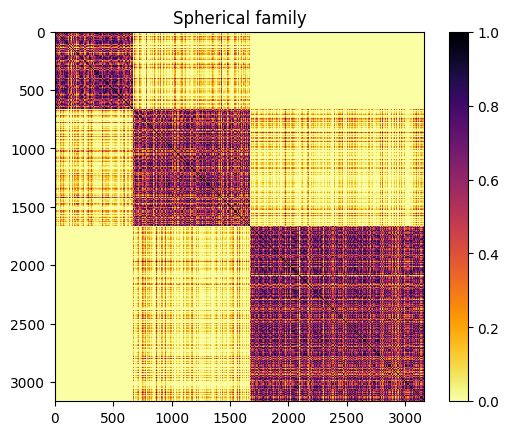

In [235]:
sph = spherical_family(absolute_distances,phi)
plt.imshow(sph, cmap='inferno_r', interpolation='nearest')
plt.colorbar()
plt.title('Spherical family')
plt.show()

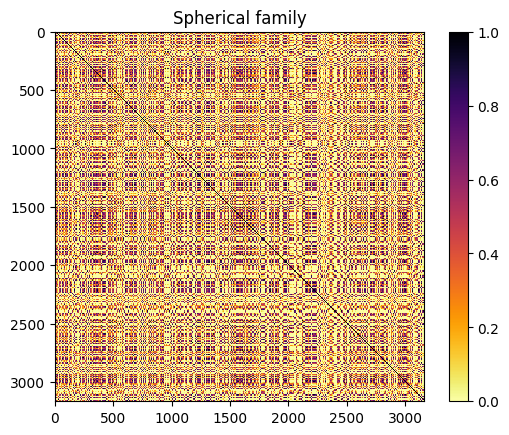

In [236]:
sph = spherical_family(shuffled_absolute_distances,phi)
plt.imshow(sph, cmap='inferno_r', interpolation='nearest')
plt.colorbar()
plt.title('Spherical family')
plt.show()

In [237]:
pca = PCA(n_components=2)
pcX = pca.fit_transform(groups)


sorted_indices = np.argsort(pcX[:,0])
sorted_groups = groups[sorted_indices,:]

distances = np.linalg.norm(sorted_groups[:,np.newaxis] - sorted_groups[np.newaxis,:],axis=2)
pc_absolute_distances = np.abs(distances)



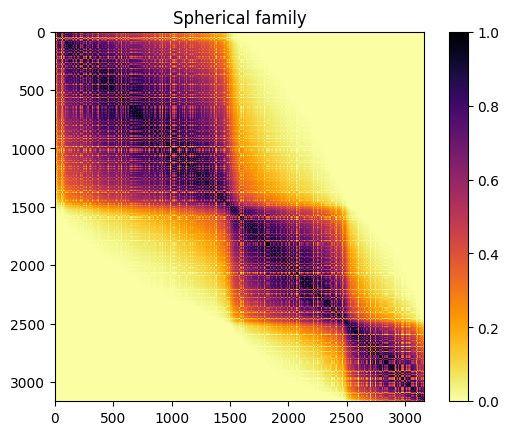

In [238]:
sph = spherical_family(pc_absolute_distances,phi)
plt.imshow(sph, cmap='inferno_r', interpolation='nearest')
plt.colorbar()
plt.title('Spherical family')
plt.show()

In [278]:
J = 1000
K = 10

nrows = sorted_groups.shape[0]

df_den = nrows - K
df_num = K -1

kjsplits = np.zeros((J,K),dtype=int)
kjsplits[:,-1] = nrows - 1
kjmeans = np.zeros((J,K))
jF = np.zeros(J)

global_mean = sorted_groups[:,0].mean()
for j in range(J):
    kprev = 0
    within = 0
    between = 0
    itr = 0
    for k in range(K-1):
        kcurr = np.random.randint(kprev+1,nrows-K+itr)
        kjmean = sorted_groups[kprev:kcurr,0].mean()
        kjmeans[j,k] = kjmean
        kjsplits[j,k] = kcurr
        within += ((sorted_groups[kprev:kcurr,0] - kjmean) ** 2).sum()
        between += (kcurr - kprev) * (kjmean - global_mean) ** 2
        kprev = kcurr
        itr += 1
    kjmean = sorted_groups[kprev:,0].mean()
    kjmeans[j,-1] = kjmean
    within += ((sorted_groups[kprev:,0] - kjmean) ** 2).sum()
    # double check indexing
    between += (kcurr - kprev) * (kjmean - global_mean) ** 2
    jF[j] = between / within * df_den / df_num


argmax_F = np.argmax(jF)
best_split = kjsplits[argmax_F]

In [279]:
best_matrix = np.zeros((nrows,nrows))
sph = spherical_family(pc_absolute_distances,phi)
k1 = 0
for k in range(K):
    k2 = best_split[k]
    best_matrix[k1:k2,k1:k2] = sph[k1:k2,k1:k2]
    k1 = k2

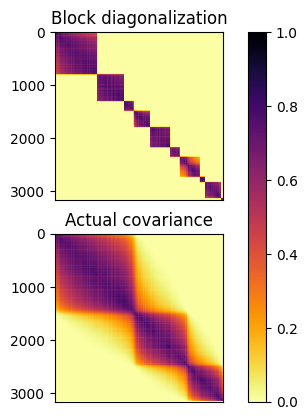

In [280]:

# Create a figure and axis
fig, ax = plt.subplots(2,1)


im1 = ax[0].imshow(best_matrix, cmap='inferno_r')
im2 = ax[1].imshow(sph, cmap='inferno_r')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xticks([])
ax[1].set_xticks([])

ax[0].set_title("Block diagonalization")
ax[1].set_title('Actual covariance')

fig.colorbar(im1,ax=ax)
# fig.title('Spherical family')

plt.show()

In [253]:
%%timeit
np.linalg.inv(sph)

2.31 s ± 390 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [281]:
%%timeit
k1 = 0
for k in range(K):
    k2 = best_split[k]
    np.linalg.inv(sph[k1:k2,k1:k2])
    k1 = k2

58 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### What happens to the sorting when there is not a cline?

The answer is no bueno.

In [77]:
ndim = 2
val = 3
mu1 = np.array([val,val])
mu2 = np.array([val,-val])
mu3 = np.array([-val,val])
mu4 = np.array([-val,-val])
sig = np.eye(ndim,ndim) * 0.75

group1 = np.random.multivariate_normal(mu1,sig,100)
group2 = np.random.multivariate_normal(mu2,sig,100)
group3 = np.random.multivariate_normal(mu3,sig,100)
group4 = np.random.multivariate_normal(mu4,sig,100)
groups = np.concatenate((group1,group2,group3,group4))
copied = deepcopy(groups)
distances = np.linalg.norm(copied[:,np.newaxis] - copied[np.newaxis,:],axis=2)
absolute_distances = np.abs(distances)

np.random.shuffle(groups)
distances = np.linalg.norm(groups[:,np.newaxis] - groups[np.newaxis,:],axis=2)
shuffled_absolute_distances = np.abs(distances)




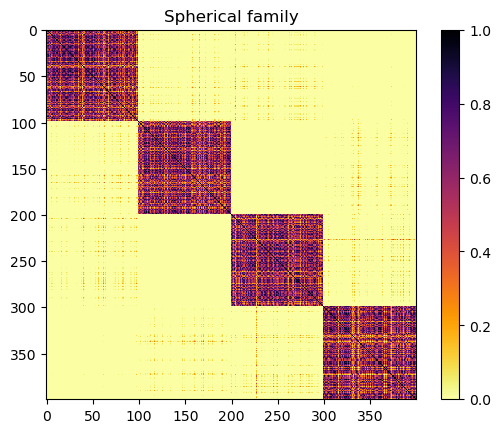

In [78]:
sph = spherical_family(absolute_distances,5)
plt.imshow(sph, cmap='inferno_r', interpolation='nearest')
plt.colorbar()
plt.title('Spherical family')
plt.show()

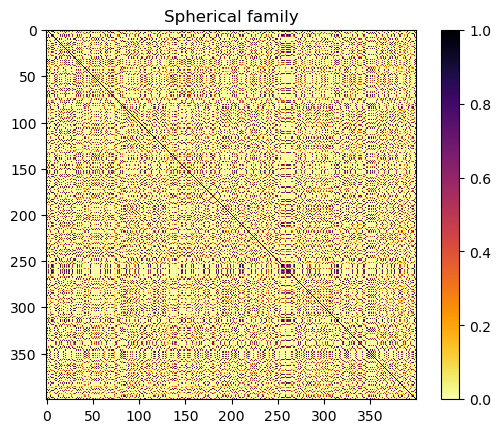

In [79]:
sph = spherical_family(shuffled_absolute_distances,5)
plt.imshow(sph, cmap='inferno_r', interpolation='nearest')
plt.colorbar()
plt.title('Spherical family')
plt.show()

In [80]:

sorted_indices = np.argsort(groups[:,0])
sorted_groups = groups[sorted_indices,:]
sorted_indices = np.argsort(sorted_groups[:,1])
sorted_groups = sorted_groups[sorted_indices,:]

distances = np.linalg.norm(sorted_groups[:,np.newaxis] - sorted_groups[np.newaxis,:],axis=2)
sorted_absolute_distances = np.abs(distances)


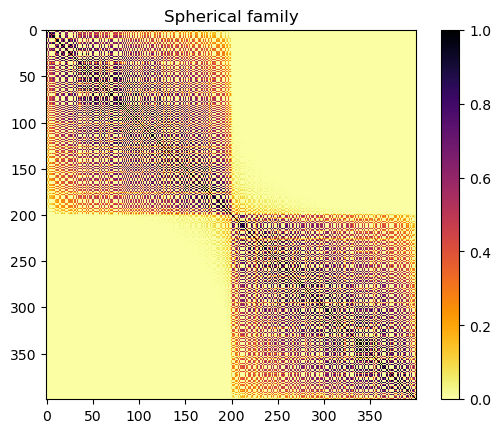

In [81]:
sph = spherical_family(sorted_absolute_distances,5)
plt.imshow(sph, cmap='inferno_r', interpolation='nearest')
plt.colorbar()
plt.title('Spherical family')
plt.show()

(-5.0, 5.0)

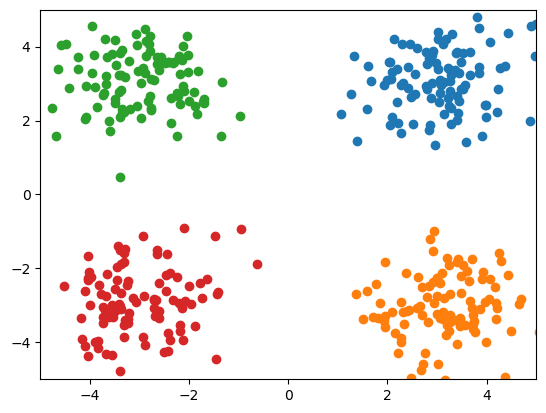

In [82]:
plt.scatter(group1[:,0],group1[:,1])
plt.scatter(group2[:,0],group2[:,1])
plt.scatter(group3[:,0],group3[:,1])
plt.scatter(group4[:,0],group4[:,1])
plt.ylim(-5,5)
plt.xlim(-5,5)